In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchsummary import summary
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np
from tqdm import tqdm
import random

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
class BasicBlock(nn.Module):

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [4]:
class ResNetSmall(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNetSmall, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(64, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        downsample = None
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)


    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
layers=[1, 1, 1, 1]
modelsmall = ResNetSmall(BasicBlock, layers).to(device)
summary(modelsmall, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
            Conv2d-3           [-1, 16, 32, 32]           2,304
       BatchNorm2d-4           [-1, 16, 32, 32]              32
            Conv2d-5           [-1, 16, 32, 32]           2,304
       BatchNorm2d-6           [-1, 16, 32, 32]              32
        BasicBlock-7           [-1, 16, 32, 32]               0
            Conv2d-8           [-1, 32, 16, 16]           4,608
       BatchNorm2d-9           [-1, 32, 16, 16]              64
           Conv2d-10           [-1, 32, 16, 16]           9,216
      BatchNorm2d-11           [-1, 32, 16, 16]              64
           Conv2d-12           [-1, 32, 16, 16]             512
      BatchNorm2d-13           [-1, 32, 16, 16]              64
       BasicBlock-14           [-1, 32,

In [5]:
class ResNetMedium(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNetMedium, self).__init__()
        self.in_planes = 32

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.layer1 = self._make_layer(block, 32, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 64, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 128, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(256, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        downsample = None
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)


    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x
    
modelmedium = ResNetMedium(BasicBlock, layers).to(device)
summary(modelmedium, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
            Conv2d-3           [-1, 32, 32, 32]           9,216
       BatchNorm2d-4           [-1, 32, 32, 32]              64
            Conv2d-5           [-1, 32, 32, 32]           9,216
       BatchNorm2d-6           [-1, 32, 32, 32]              64
        BasicBlock-7           [-1, 32, 32, 32]               0
            Conv2d-8           [-1, 64, 16, 16]          18,432
       BatchNorm2d-9           [-1, 64, 16, 16]             128
           Conv2d-10           [-1, 64, 16, 16]          36,864
      BatchNorm2d-11           [-1, 64, 16, 16]             128
           Conv2d-12           [-1, 64, 16, 16]           2,048
      BatchNorm2d-13           [-1, 64, 16, 16]             128
       BasicBlock-14           [-1, 64,

In [6]:
class ResNetLarge(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNetLarge, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[2], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        downsample = None
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)


    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x
    
modellarge = ResNetLarge(BasicBlock, layers).to(device)
summary(modellarge, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8          [-1, 128, 16, 16]          73,728
       BatchNorm2d-9          [-1, 128, 16, 16]             256
           Conv2d-10          [-1, 128, 16, 16]         147,456
      BatchNorm2d-11          [-1, 128, 16, 16]             256
           Conv2d-12          [-1, 128, 16, 16]           8,192
      BatchNorm2d-13          [-1, 128, 16, 16]             256
       BasicBlock-14          [-1, 128,

In [7]:
# Load the dataset
# Defining Transformers for train and test set differently
train_transform = transforms.Compose([
    transforms.RandomRotation(5),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomCrop(32, padding=2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])
test_transform = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean = [0.4914, 0.4822, 0.4465], 
                                                std = [0.2023, 0.1994, 0.2010])
                       ])
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


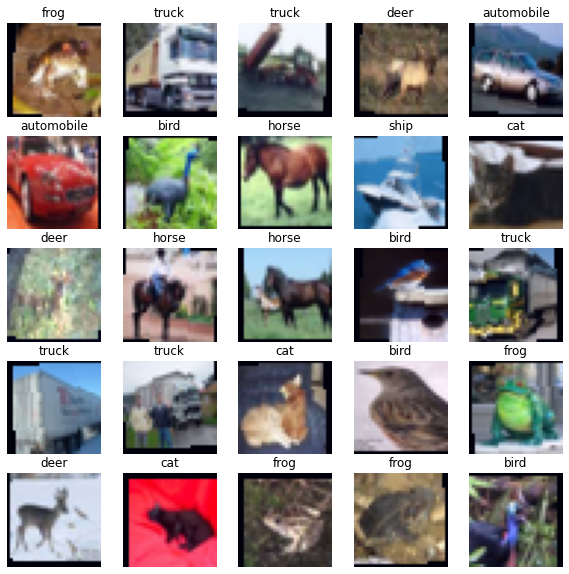

In [8]:
def plot_images(images, labels, classes, normalize = False):
    n_images = len(images)
    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))
    fig = plt.figure(figsize = (10, 10))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)       
        image = images[i]
        if normalize:
            image_min = image.min()
            image_max = image.max()
            image.clamp_(min = image_min, max = image_max)
            image.add_(-image_min).div_(image_max - image_min + 1e-5)
        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        ax.set_title(classes[labels[i]])
        ax.axis('off')

N_IMAGES = 25
images, labels = zip(*[(image, label) for image, label in [train_dataset[i] for i in range(N_IMAGES)]])
classes = test_dataset.classes
plot_images(images, labels, classes, normalize = True)

In [9]:
def train(data_loader, model, criterion, optimizer, scheduler = None, early_stop=None):
    learning_rate_tracker = {}
    epoch_correct = 0
    running_loss = 0.0
    model.train()
    for i, (images, labels) in tqdm(enumerate(data_loader)):
        learning_rate_tracker[i] = optimizer.param_groups[0]['lr']
        
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels) 
        running_loss += loss.item()
        predicted = torch.max(outputs.data, 1)[1]
        epoch_correct += (predicted == labels).sum().item()
        
        if early_stop and i==early_stop:
            break
            
        loss.backward()
        optimizer.step()
        if scheduler:
            scheduler.step()

    
    return epoch_correct , running_loss, learning_rate_tracker
    
def evaluate(data_loader, model, criterion):
    epoch_correct = 0
    running_loss = 0.0
    y_true = []
    y_pred = []
    model.eval()
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels) 
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            epoch_correct += (predicted == labels).sum().item()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    
    return epoch_correct, running_loss, y_true, y_pred

In [10]:
lr_min = 7*1e-5
lr_max = 1e-2
epochs = 30
step_size = (len(train_dataset)/64) // 2

model = modelsmall
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr_min, momentum=0.9, nesterov=True)
scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=lr_min, max_lr=lr_max, step_size_up=step_size, step_size_down=step_size, gamma=0.9999, mode="exp_range", cycle_momentum=False)
lr_tracker = {}

train_loss_history_small = []
train_acc_history_small = []
val_loss_history_small = []
val_acc_history_small = []
y_pred_small = []
y_true_small = []
best_valid_loss = float('inf')

for epoch in range(epochs):
    print(f"Epoch: {epoch+1}/{epochs}")
    correct, loss, rate_tracker = train(data_loader=train_loader, model=model, criterion=criterion, optimizer=optimizer, scheduler=scheduler)
    accuracy = correct / len(train_loader.dataset)
    loss = loss / len(train_loader)
    train_loss = loss
    train_acc_history_small.append(accuracy)
    train_loss_history_small.append(loss)
    for key in rate_tracker.keys():
        lr_tracker[(epoch,key)] = rate_tracker[key]
    correct, loss, y_true_small, y_pred_small = evaluate(data_loader = test_loader, model=model, criterion=criterion)
    validation_accuracy = correct / len(test_loader.dataset)
    validation_loss = loss / len(test_loader)
    print(f"Train Accuracy: {accuracy*100:.2f}%, Train Loss: {train_loss}")
    print(f"Validation Accuracy: {validation_accuracy*100:.2f}%, Validtion Loss: {validation_loss}")
    if validation_loss < best_valid_loss:
        best_valid_loss = validation_loss
        torch.save(model.state_dict(), 'ResNetSmall.pt')
    val_acc_history_small.append(validation_accuracy)
    val_loss_history_small.append(validation_loss)

Epoch: 1/30


782it [00:06, 112.91it/s]


Train Accuracy: 37.43%, Train Loss: 1.6940355457918113
Validation Accuracy: 51.56%, Validtion Loss: 1.3305813263935649
Epoch: 2/30


782it [00:06, 113.91it/s]


Train Accuracy: 53.26%, Train Loss: 1.2913998059756921
Validation Accuracy: 60.88%, Validtion Loss: 1.091045123376664
Epoch: 3/30


782it [00:06, 115.09it/s]


Train Accuracy: 59.74%, Train Loss: 1.1185242401059632
Validation Accuracy: 64.55%, Validtion Loss: 0.979570109373445
Epoch: 4/30


782it [00:06, 114.55it/s]


Train Accuracy: 63.62%, Train Loss: 1.0192154473660853
Validation Accuracy: 67.22%, Validtion Loss: 0.9076632489064697
Epoch: 5/30


782it [00:06, 113.78it/s]


Train Accuracy: 65.90%, Train Loss: 0.9565953075733331
Validation Accuracy: 69.08%, Validtion Loss: 0.8635459155034108
Epoch: 6/30


782it [00:06, 112.37it/s]


Train Accuracy: 67.65%, Train Loss: 0.9102438746968193
Validation Accuracy: 70.52%, Validtion Loss: 0.8266017847000413
Epoch: 7/30


782it [00:06, 112.04it/s]


Train Accuracy: 68.91%, Train Loss: 0.878432925018813
Validation Accuracy: 71.59%, Validtion Loss: 0.8003581481374753
Epoch: 8/30


782it [00:06, 112.52it/s]


Train Accuracy: 70.03%, Train Loss: 0.8444180276692675
Validation Accuracy: 72.19%, Validtion Loss: 0.776954142720836
Epoch: 9/30


782it [00:07, 111.62it/s]


Train Accuracy: 71.06%, Train Loss: 0.81726865923923
Validation Accuracy: 73.56%, Validtion Loss: 0.7516259551048279
Epoch: 10/30


782it [00:06, 114.53it/s]


Train Accuracy: 72.16%, Train Loss: 0.7934487130483399
Validation Accuracy: 73.99%, Validtion Loss: 0.7343324195047852
Epoch: 11/30


782it [00:06, 111.99it/s]


Train Accuracy: 73.02%, Train Loss: 0.7704632945377808
Validation Accuracy: 74.75%, Validtion Loss: 0.7207038882811359
Epoch: 12/30


782it [00:06, 113.69it/s]


Train Accuracy: 73.79%, Train Loss: 0.7507825376813674
Validation Accuracy: 75.27%, Validtion Loss: 0.7004741320184841
Epoch: 13/30


782it [00:06, 113.30it/s]


Train Accuracy: 74.39%, Train Loss: 0.731177929150479
Validation Accuracy: 75.96%, Validtion Loss: 0.6868829958757777
Epoch: 14/30


782it [00:06, 113.10it/s]


Train Accuracy: 74.91%, Train Loss: 0.7172398762324886
Validation Accuracy: 76.33%, Validtion Loss: 0.6770442268651002
Epoch: 15/30


782it [00:06, 115.38it/s]


Train Accuracy: 75.54%, Train Loss: 0.7010727685202113
Validation Accuracy: 76.59%, Validtion Loss: 0.6638750716759141
Epoch: 16/30


782it [00:06, 114.42it/s]


Train Accuracy: 75.95%, Train Loss: 0.690705521675327
Validation Accuracy: 77.25%, Validtion Loss: 0.6499621431539013
Epoch: 17/30


782it [00:06, 115.75it/s]


Train Accuracy: 76.32%, Train Loss: 0.6801932245264273
Validation Accuracy: 77.25%, Validtion Loss: 0.6490999082471155
Epoch: 18/30


782it [00:06, 112.70it/s]


Train Accuracy: 76.78%, Train Loss: 0.6659728383164272
Validation Accuracy: 77.70%, Validtion Loss: 0.6452860120375445
Epoch: 19/30


782it [00:06, 114.43it/s]


Train Accuracy: 77.07%, Train Loss: 0.6554007500486301
Validation Accuracy: 77.82%, Validtion Loss: 0.6353931725025177
Epoch: 20/30


782it [00:07, 110.28it/s]


Train Accuracy: 77.60%, Train Loss: 0.6459503564078485
Validation Accuracy: 77.94%, Validtion Loss: 0.6287576897888426
Epoch: 21/30


782it [00:06, 114.27it/s]


Train Accuracy: 77.65%, Train Loss: 0.641810862952486
Validation Accuracy: 78.29%, Validtion Loss: 0.6264573288191656
Epoch: 22/30


782it [00:06, 115.60it/s]


Train Accuracy: 77.90%, Train Loss: 0.6306423859294418
Validation Accuracy: 78.57%, Validtion Loss: 0.6169414829676318
Epoch: 23/30


782it [00:06, 114.11it/s]


Train Accuracy: 78.32%, Train Loss: 0.6250847952292703
Validation Accuracy: 78.79%, Validtion Loss: 0.6141623087749359
Epoch: 24/30


782it [00:06, 112.86it/s]


Train Accuracy: 78.69%, Train Loss: 0.6199200806943962
Validation Accuracy: 78.84%, Validtion Loss: 0.6079623046194672
Epoch: 25/30


782it [00:06, 112.16it/s]


Train Accuracy: 78.84%, Train Loss: 0.6116859697167526
Validation Accuracy: 78.94%, Validtion Loss: 0.6019205781304913
Epoch: 26/30


782it [00:06, 112.38it/s]


Train Accuracy: 79.00%, Train Loss: 0.6086551579444305
Validation Accuracy: 79.06%, Validtion Loss: 0.6015545621419408
Epoch: 27/30


782it [00:06, 112.63it/s]


Train Accuracy: 79.33%, Train Loss: 0.5973006961748119
Validation Accuracy: 79.63%, Validtion Loss: 0.5963240896060968
Epoch: 28/30


782it [00:06, 114.51it/s]


Train Accuracy: 79.38%, Train Loss: 0.5956948168975923
Validation Accuracy: 79.36%, Validtion Loss: 0.5953323962582144
Epoch: 29/30


782it [00:06, 113.07it/s]


Train Accuracy: 79.45%, Train Loss: 0.59215067174581
Validation Accuracy: 79.50%, Validtion Loss: 0.59144402575341
Epoch: 30/30


782it [00:06, 113.69it/s]


Train Accuracy: 79.81%, Train Loss: 0.5870621241343296
Validation Accuracy: 79.74%, Validtion Loss: 0.5894114293490246


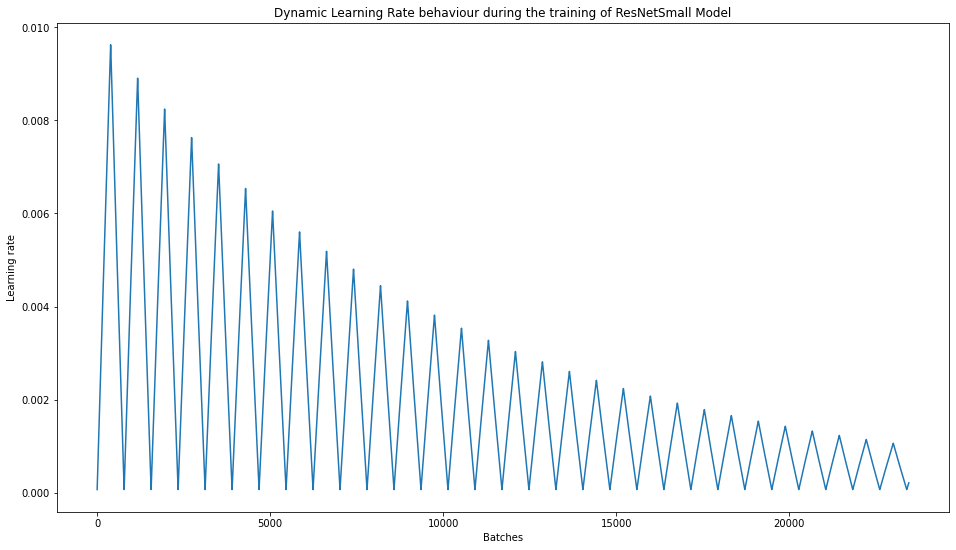

In [11]:
fig, ax = plt.subplots(figsize=(16,9))
plt.title('Dynamic Learning Rate behaviour during the training of ResNetSmall Model')
plt.plot(range(len(lr_tracker)), lr_tracker.values())
plt.xlabel('Batches')
plt.ylabel('Learning rate')
plt.show()

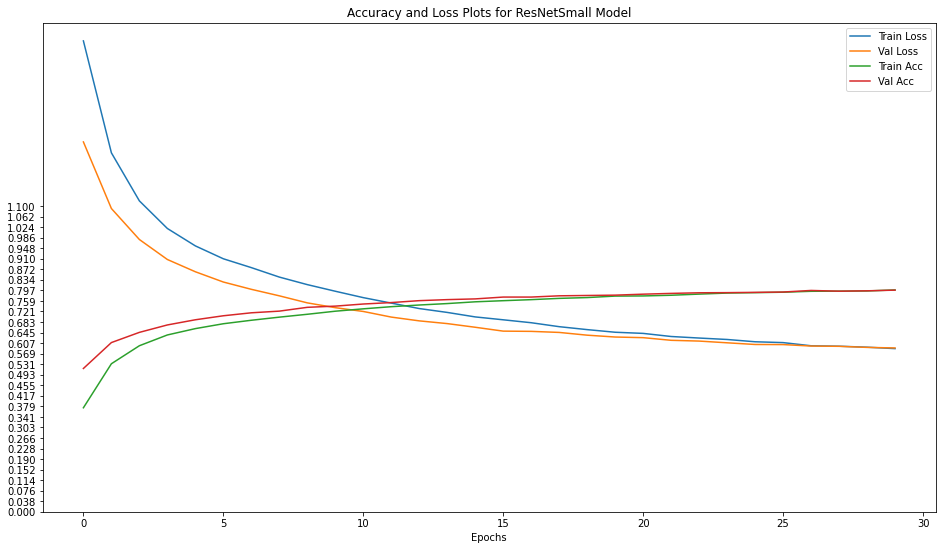

In [12]:
fig, ax = plt.subplots(figsize=(16,9))

plt.title('Accuracy and Loss Plots for ResNetSmall Model')
plt.plot(train_loss_history_small, label='Train Loss')
plt.plot(val_loss_history_small, label='Val Loss')
plt.plot(train_acc_history_small, label='Train Acc')  
plt.plot(val_acc_history_small, label='Val Acc')
plt.legend()
plt.xlabel("Epochs")
yticks = np.linspace(0, 1.1, num=30)
ax.set_yticks(yticks)
plt.show()  

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'airplane'),
  Text(1, 0, 'automobile'),
  Text(2, 0, 'bird'),
  Text(3, 0, 'cat'),
  Text(4, 0, 'deer'),
  Text(5, 0, 'dog'),
  Text(6, 0, 'frog'),
  Text(7, 0, 'horse'),
  Text(8, 0, 'ship'),
  Text(9, 0, 'truck')])

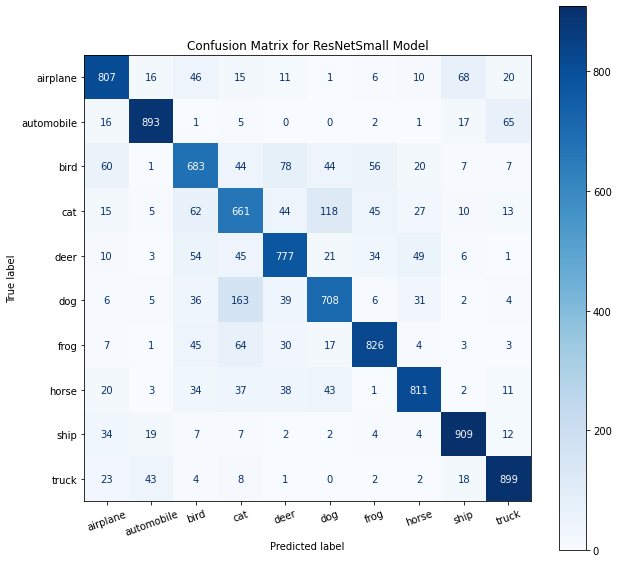

In [13]:
# Calculate the confusion matrix
cm = confusion_matrix(y_true_small, y_pred_small)
fig = plt.figure(figsize = (10, 10));
ax = fig.add_subplot(1, 1, 1);
ax.set_title('Confusion Matrix for ResNetSmall Model')
cm = ConfusionMatrixDisplay(cm, display_labels = classes);
cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
plt.xticks(rotation = 20)

In [14]:
lr_min = 7*1e-5
lr_max = 1e-2
epochs = 30
step_size = (len(train_dataset)/64) // 2

model = modelmedium
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr_min, momentum=0.9, nesterov=True)
scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=lr_min, max_lr=lr_max, step_size_up=step_size, step_size_down=step_size, gamma=0.9999, mode="exp_range", cycle_momentum=False)
lr_tracker = {}

train_loss_history_medium = []
train_acc_history_medium = []
val_loss_history_medium = []
val_acc_history_medium = []
y_pred_medium = []
y_true_medium = []
best_valid_loss = float('inf')

for epoch in range(epochs):
    print(f"Epoch: {epoch+1}/{epochs}")
    correct, loss, rate_tracker = train(data_loader=train_loader, model=model, criterion=criterion, optimizer=optimizer, scheduler=scheduler)
    accuracy = correct / len(train_loader.dataset)
    loss = loss / len(train_loader)
    train_loss = loss
    train_acc_history_medium.append(accuracy)
    train_loss_history_medium.append(loss)
    for key in rate_tracker.keys():
        lr_tracker[(epoch,key)] = rate_tracker[key]
    correct, loss, y_true_medium, y_pred_medium = evaluate(data_loader = test_loader, model=model, criterion=criterion)
    validation_accuracy = correct / len(test_loader.dataset)
    validation_loss = loss / len(test_loader)
    print(f"Train Accuracy: {accuracy*100:.2f}%, Train Loss: {train_loss}")
    print(f"Validation Accuracy: {validation_accuracy*100:.2f}%, Validtion Loss: {validation_loss}")
    if validation_loss < best_valid_loss:
        best_valid_loss = validation_loss
        torch.save(model.state_dict(), 'ResNetMedium.pt')
    val_acc_history_medium.append(validation_accuracy)
    val_loss_history_medium.append(validation_loss)

Epoch: 1/30


782it [00:09, 80.19it/s] 


Train Accuracy: 46.01%, Train Loss: 1.4704693907971882
Validation Accuracy: 64.18%, Validtion Loss: 0.9979790692116804
Epoch: 2/30


782it [00:07, 101.65it/s]


Train Accuracy: 63.63%, Train Loss: 1.0212342376294343
Validation Accuracy: 70.68%, Validtion Loss: 0.807715127042904
Epoch: 3/30


782it [00:07, 98.03it/s] 


Train Accuracy: 69.39%, Train Loss: 0.8639339867150387
Validation Accuracy: 75.09%, Validtion Loss: 0.7049870827015797
Epoch: 4/30


782it [00:07, 100.04it/s]


Train Accuracy: 73.73%, Train Loss: 0.7502617635156797
Validation Accuracy: 78.24%, Validtion Loss: 0.6223318316754262
Epoch: 5/30


782it [00:07, 100.90it/s]


Train Accuracy: 76.21%, Train Loss: 0.6778686083567417
Validation Accuracy: 79.76%, Validtion Loss: 0.5776076592077874
Epoch: 6/30


782it [00:07, 101.38it/s]


Train Accuracy: 78.44%, Train Loss: 0.6201398900860106
Validation Accuracy: 81.38%, Validtion Loss: 0.5416534808790607
Epoch: 7/30


782it [00:07, 98.71it/s] 


Train Accuracy: 79.82%, Train Loss: 0.5781882173188811
Validation Accuracy: 82.76%, Validtion Loss: 0.5101163288590255
Epoch: 8/30


782it [00:07, 99.45it/s] 


Train Accuracy: 81.30%, Train Loss: 0.5405041068373129
Validation Accuracy: 83.35%, Validtion Loss: 0.4845887620927422
Epoch: 9/30


782it [00:07, 99.20it/s] 


Train Accuracy: 82.24%, Train Loss: 0.5123471110639974
Validation Accuracy: 84.02%, Validtion Loss: 0.4685161110891658
Epoch: 10/30


782it [00:07, 101.88it/s]


Train Accuracy: 83.24%, Train Loss: 0.4826135989612021
Validation Accuracy: 84.57%, Validtion Loss: 0.4543295859531232
Epoch: 11/30


782it [00:07, 99.88it/s] 


Train Accuracy: 83.94%, Train Loss: 0.4611193978268167
Validation Accuracy: 85.42%, Validtion Loss: 0.4404318835704949
Epoch: 12/30


782it [00:07, 99.59it/s] 


Train Accuracy: 84.73%, Train Loss: 0.43658940006247565
Validation Accuracy: 85.46%, Validtion Loss: 0.43136441660155156
Epoch: 13/30


782it [00:07, 100.75it/s]


Train Accuracy: 85.26%, Train Loss: 0.4244391067749094
Validation Accuracy: 85.91%, Validtion Loss: 0.4200652183810617
Epoch: 14/30


782it [00:07, 99.23it/s] 


Train Accuracy: 85.95%, Train Loss: 0.40334861603615535
Validation Accuracy: 86.04%, Validtion Loss: 0.41111762318641515
Epoch: 15/30


782it [00:07, 98.75it/s] 


Train Accuracy: 86.29%, Train Loss: 0.3896152164282091
Validation Accuracy: 86.21%, Validtion Loss: 0.3999946048115469
Epoch: 16/30


782it [00:07, 99.40it/s] 


Train Accuracy: 86.92%, Train Loss: 0.37767335082716347
Validation Accuracy: 86.67%, Validtion Loss: 0.39791266335423586
Epoch: 17/30


782it [00:07, 99.08it/s] 


Train Accuracy: 87.47%, Train Loss: 0.36414406625815976
Validation Accuracy: 86.93%, Validtion Loss: 0.39127714761123533
Epoch: 18/30


782it [00:07, 98.88it/s] 


Train Accuracy: 87.92%, Train Loss: 0.34879560254114056
Validation Accuracy: 86.74%, Validtion Loss: 0.3902110893065762
Epoch: 19/30


782it [00:07, 99.15it/s] 


Train Accuracy: 88.36%, Train Loss: 0.3393805970621231
Validation Accuracy: 87.03%, Validtion Loss: 0.3856867074871519
Epoch: 20/30


782it [00:07, 100.39it/s]


Train Accuracy: 88.54%, Train Loss: 0.32790406579937775
Validation Accuracy: 87.50%, Validtion Loss: 0.37473287760831747
Epoch: 21/30


782it [00:07, 99.78it/s] 


Train Accuracy: 89.10%, Train Loss: 0.31697526466472986
Validation Accuracy: 87.32%, Validtion Loss: 0.3754765532768456
Epoch: 22/30


782it [00:07, 100.27it/s]


Train Accuracy: 89.21%, Train Loss: 0.3124353203379437
Validation Accuracy: 87.71%, Validtion Loss: 0.37329159923799476
Epoch: 23/30


782it [00:07, 99.35it/s] 


Train Accuracy: 89.41%, Train Loss: 0.3041162289907713
Validation Accuracy: 87.75%, Validtion Loss: 0.3693670731536142
Epoch: 24/30


782it [00:07, 98.55it/s] 


Train Accuracy: 89.77%, Train Loss: 0.2953778269422024
Validation Accuracy: 87.87%, Validtion Loss: 0.3690194018232595
Epoch: 25/30


782it [00:07, 100.97it/s]


Train Accuracy: 89.91%, Train Loss: 0.2907095183439724
Validation Accuracy: 87.93%, Validtion Loss: 0.36683760877627475
Epoch: 26/30


782it [00:07, 100.94it/s]


Train Accuracy: 90.30%, Train Loss: 0.2816490097271512
Validation Accuracy: 87.85%, Validtion Loss: 0.36197935220352406
Epoch: 27/30


782it [00:07, 98.38it/s] 


Train Accuracy: 90.55%, Train Loss: 0.2729599878615926
Validation Accuracy: 88.11%, Validtion Loss: 0.3621630854667372
Epoch: 28/30


782it [00:07, 98.15it/s] 


Train Accuracy: 90.74%, Train Loss: 0.26805852787078494
Validation Accuracy: 87.95%, Validtion Loss: 0.3639676746004706
Epoch: 29/30


782it [00:07, 98.05it/s] 


Train Accuracy: 90.94%, Train Loss: 0.2639118067710601
Validation Accuracy: 88.21%, Validtion Loss: 0.3573440781254677
Epoch: 30/30


782it [00:07, 101.58it/s]


Train Accuracy: 91.19%, Train Loss: 0.2561107828184162
Validation Accuracy: 88.05%, Validtion Loss: 0.3613378294998673


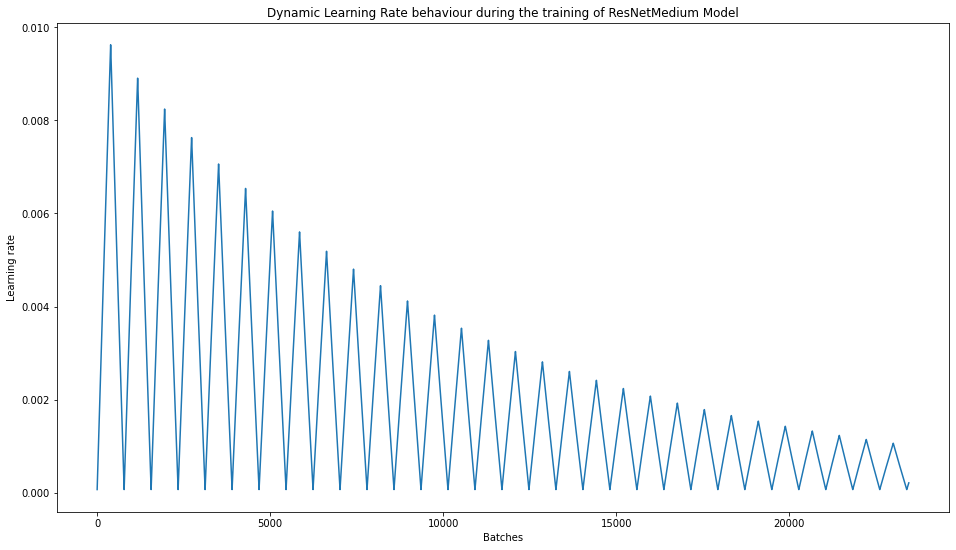

In [15]:
fig, ax = plt.subplots(figsize=(16,9))
plt.title('Dynamic Learning Rate behaviour during the training of ResNetMedium Model')
plt.plot(range(len(lr_tracker)), lr_tracker.values())
plt.xlabel('Batches')
plt.ylabel('Learning rate')
plt.show()

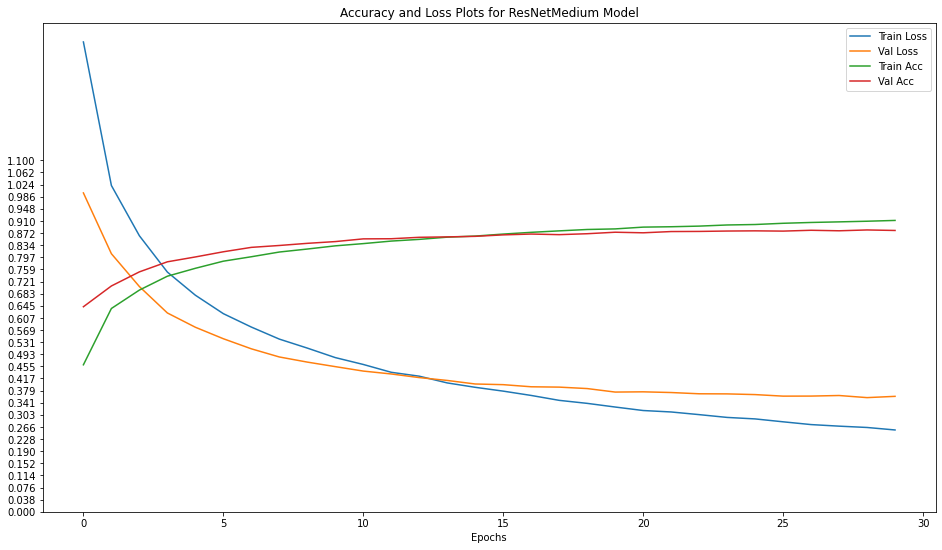

In [16]:
fig, ax = plt.subplots(figsize=(16,9))

plt.title('Accuracy and Loss Plots for ResNetMedium Model')
plt.plot(train_loss_history_medium, label='Train Loss')
plt.plot(val_loss_history_medium, label='Val Loss')
plt.plot(train_acc_history_medium, label='Train Acc')  
plt.plot(val_acc_history_medium, label='Val Acc')
plt.legend()
plt.xlabel("Epochs")
yticks = np.linspace(0, 1.1, num=30)
ax.set_yticks(yticks)
plt.show()  

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'airplane'),
  Text(1, 0, 'automobile'),
  Text(2, 0, 'bird'),
  Text(3, 0, 'cat'),
  Text(4, 0, 'deer'),
  Text(5, 0, 'dog'),
  Text(6, 0, 'frog'),
  Text(7, 0, 'horse'),
  Text(8, 0, 'ship'),
  Text(9, 0, 'truck')])

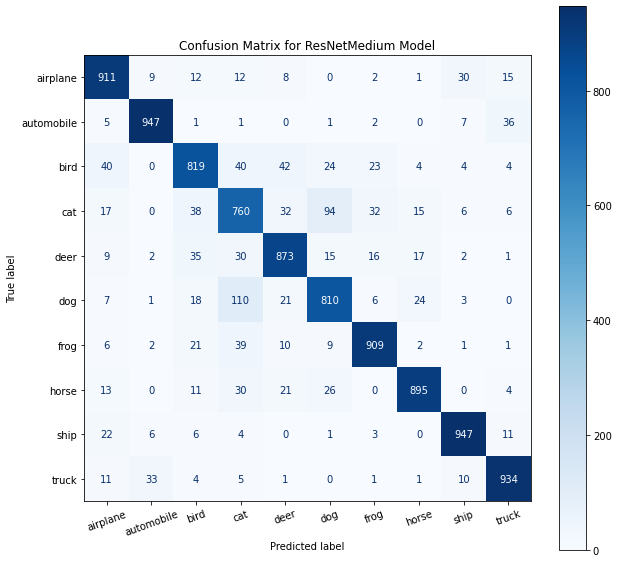

In [17]:
# Calculate the confusion matrix
cm = confusion_matrix(y_true_medium, y_pred_medium)
fig = plt.figure(figsize = (10, 10));
ax = fig.add_subplot(1, 1, 1);
ax.set_title('Confusion Matrix for ResNetMedium Model')
cm = ConfusionMatrixDisplay(cm, display_labels = classes);
cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
plt.xticks(rotation = 20)

In [18]:
lr_min = 7*1e-5
lr_max = 1e-2
epochs = 30
step_size = (len(train_dataset)/64) // 2

model = modellarge
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr_min, momentum=0.9, nesterov=True)
scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=lr_min, max_lr=lr_max, step_size_up=step_size, step_size_down=step_size, gamma=0.9999, mode="exp_range", cycle_momentum=False)
lr_tracker = {}

train_loss_history_large = []
train_acc_history_large = []
val_loss_history_large = []
val_acc_history_large = []
y_pred_large = []
y_true_large = []
best_valid_loss = float('inf')

for epoch in range(epochs):
    print(f"Epoch: {epoch+1}/{epochs}")
    correct, loss, rate_tracker = train(data_loader=train_loader, model=model, criterion=criterion, optimizer=optimizer, scheduler=scheduler)
    accuracy = correct / len(train_loader.dataset)
    loss = loss / len(train_loader)
    train_loss = loss
    train_acc_history_large.append(accuracy)
    train_loss_history_large.append(loss)
    for key in rate_tracker.keys():
        lr_tracker[(epoch,key)] = rate_tracker[key]
    correct, loss, y_true_large, y_pred_large = evaluate(data_loader = test_loader, model=model, criterion=criterion)
    validation_accuracy = correct / len(test_loader.dataset)
    validation_loss = loss / len(test_loader)
    print(f"Train Accuracy: {accuracy*100:.2f}%, Train Loss: {train_loss}")
    print(f"Validation Accuracy: {validation_accuracy*100:.2f}%, Validtion Loss: {validation_loss}")
    if validation_loss < best_valid_loss:
        best_valid_loss = validation_loss
        torch.save(model.state_dict(), 'ResNetLarge.pt')
    val_acc_history_large.append(validation_accuracy)
    val_loss_history_large.append(validation_loss)

Epoch: 1/30


782it [00:15, 52.02it/s]


Train Accuracy: 49.22%, Train Loss: 1.397474288178222
Validation Accuracy: 67.94%, Validtion Loss: 0.8983353011927028
Epoch: 2/30


782it [00:14, 53.87it/s]


Train Accuracy: 66.45%, Train Loss: 0.9399031486047809
Validation Accuracy: 73.47%, Validtion Loss: 0.7376628745893005
Epoch: 3/30


782it [00:14, 54.48it/s]


Train Accuracy: 72.57%, Train Loss: 0.7761747479591223
Validation Accuracy: 77.84%, Validtion Loss: 0.6275963876277778
Epoch: 4/30


782it [00:14, 53.83it/s]


Train Accuracy: 76.26%, Train Loss: 0.6763065373120101
Validation Accuracy: 80.71%, Validtion Loss: 0.56342661133997
Epoch: 5/30


782it [00:14, 54.24it/s]


Train Accuracy: 79.10%, Train Loss: 0.604541775306015
Validation Accuracy: 82.27%, Validtion Loss: 0.5191047035964431
Epoch: 6/30


782it [00:14, 54.43it/s]


Train Accuracy: 80.87%, Train Loss: 0.5506300668772834
Validation Accuracy: 83.43%, Validtion Loss: 0.48963950517450927
Epoch: 7/30


782it [00:14, 54.27it/s]


Train Accuracy: 82.42%, Train Loss: 0.510678330860327
Validation Accuracy: 84.79%, Validtion Loss: 0.4534256859759616
Epoch: 8/30


782it [00:14, 53.97it/s]


Train Accuracy: 83.79%, Train Loss: 0.4684415358068693
Validation Accuracy: 85.17%, Validtion Loss: 0.43733824571226815
Epoch: 9/30


782it [00:14, 54.34it/s]


Train Accuracy: 84.67%, Train Loss: 0.44005574167841843
Validation Accuracy: 85.66%, Validtion Loss: 0.42418166900136667
Epoch: 10/30


782it [00:14, 53.99it/s]


Train Accuracy: 85.91%, Train Loss: 0.4123221172586731
Validation Accuracy: 86.35%, Validtion Loss: 0.4027150186953271
Epoch: 11/30


782it [00:14, 54.31it/s]


Train Accuracy: 86.65%, Train Loss: 0.38878647190378146
Validation Accuracy: 86.54%, Validtion Loss: 0.39699437284165884
Epoch: 12/30


782it [00:14, 54.19it/s]


Train Accuracy: 87.43%, Train Loss: 0.3685833133109238
Validation Accuracy: 86.92%, Validtion Loss: 0.38201959839292393
Epoch: 13/30


782it [00:14, 54.68it/s]


Train Accuracy: 88.07%, Train Loss: 0.3451857261569299
Validation Accuracy: 87.58%, Validtion Loss: 0.3671379339448206
Epoch: 14/30


782it [00:14, 54.43it/s]


Train Accuracy: 88.45%, Train Loss: 0.33120830225593906
Validation Accuracy: 87.77%, Validtion Loss: 0.36296693230890165
Epoch: 15/30


782it [00:14, 54.31it/s]


Train Accuracy: 89.17%, Train Loss: 0.3131773835595916
Validation Accuracy: 87.91%, Validtion Loss: 0.3584019834543489
Epoch: 16/30


782it [00:14, 54.56it/s]


Train Accuracy: 89.67%, Train Loss: 0.2986714077632293
Validation Accuracy: 88.32%, Validtion Loss: 0.35148821951477394
Epoch: 17/30


782it [00:14, 54.21it/s]


Train Accuracy: 90.17%, Train Loss: 0.28336821437415566
Validation Accuracy: 88.44%, Validtion Loss: 0.3442805570781611
Epoch: 18/30


782it [00:14, 54.56it/s]


Train Accuracy: 90.75%, Train Loss: 0.2693825533418247
Validation Accuracy: 88.50%, Validtion Loss: 0.3419212460707707
Epoch: 19/30


782it [00:14, 54.46it/s]


Train Accuracy: 91.20%, Train Loss: 0.2568760868971762
Validation Accuracy: 88.98%, Validtion Loss: 0.3309903784542327
Epoch: 20/30


782it [00:14, 54.02it/s]


Train Accuracy: 91.46%, Train Loss: 0.24661363058668725
Validation Accuracy: 89.12%, Validtion Loss: 0.3301071824541517
Epoch: 21/30


782it [00:14, 53.97it/s]


Train Accuracy: 91.94%, Train Loss: 0.23444889726407844
Validation Accuracy: 88.97%, Validtion Loss: 0.3292032579422756
Epoch: 22/30


782it [00:14, 54.47it/s]


Train Accuracy: 92.32%, Train Loss: 0.2262741798425422
Validation Accuracy: 89.31%, Validtion Loss: 0.323524169481484
Epoch: 23/30


782it [00:14, 53.76it/s]


Train Accuracy: 92.64%, Train Loss: 0.21557157910655222
Validation Accuracy: 89.47%, Validtion Loss: 0.3226177845221416
Epoch: 24/30


782it [00:14, 54.49it/s]


Train Accuracy: 92.88%, Train Loss: 0.20828395352586912
Validation Accuracy: 89.32%, Validtion Loss: 0.32242463849437464
Epoch: 25/30


782it [00:14, 54.27it/s]


Train Accuracy: 93.15%, Train Loss: 0.20018890539131812
Validation Accuracy: 89.46%, Validtion Loss: 0.31959915471969136
Epoch: 26/30


782it [00:14, 53.92it/s]


Train Accuracy: 93.44%, Train Loss: 0.19079831743712924
Validation Accuracy: 89.60%, Validtion Loss: 0.32142262312637015
Epoch: 27/30


782it [00:14, 54.55it/s]


Train Accuracy: 93.59%, Train Loss: 0.187322187392265
Validation Accuracy: 89.67%, Validtion Loss: 0.3204578890162668
Epoch: 28/30


782it [00:14, 54.43it/s]


Train Accuracy: 93.81%, Train Loss: 0.18032245187427076
Validation Accuracy: 89.73%, Validtion Loss: 0.3180904680756247
Epoch: 29/30


782it [00:14, 54.63it/s]


Train Accuracy: 94.12%, Train Loss: 0.17400676607037596
Validation Accuracy: 89.66%, Validtion Loss: 0.31555287324034487
Epoch: 30/30


782it [00:14, 54.63it/s]


Train Accuracy: 94.32%, Train Loss: 0.16717837063019234
Validation Accuracy: 89.75%, Validtion Loss: 0.3162300055668612


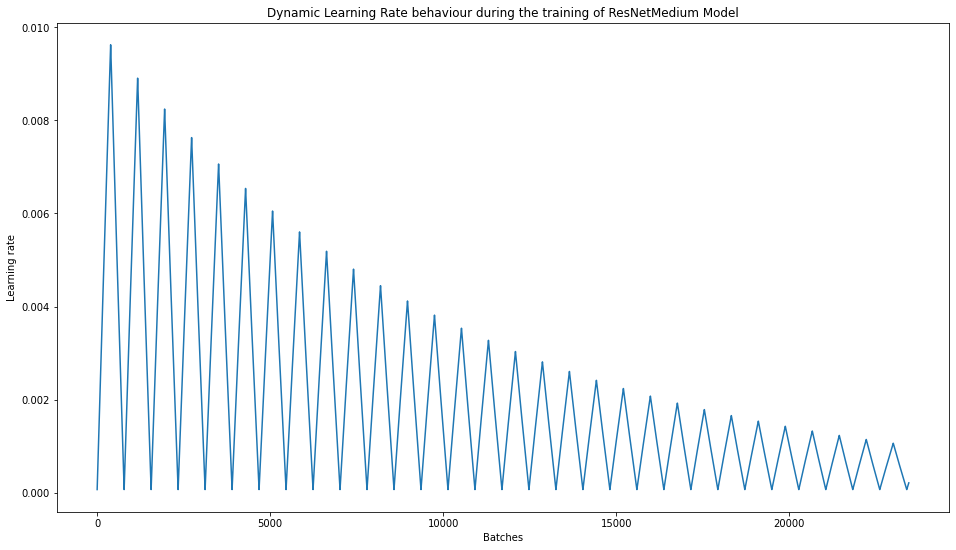

In [19]:
fig, ax = plt.subplots(figsize=(16,9))
plt.title('Dynamic Learning Rate behaviour during the training of ResNetMedium Model')
plt.plot(range(len(lr_tracker)), lr_tracker.values())
plt.xlabel('Batches')
plt.ylabel('Learning rate')
plt.show()

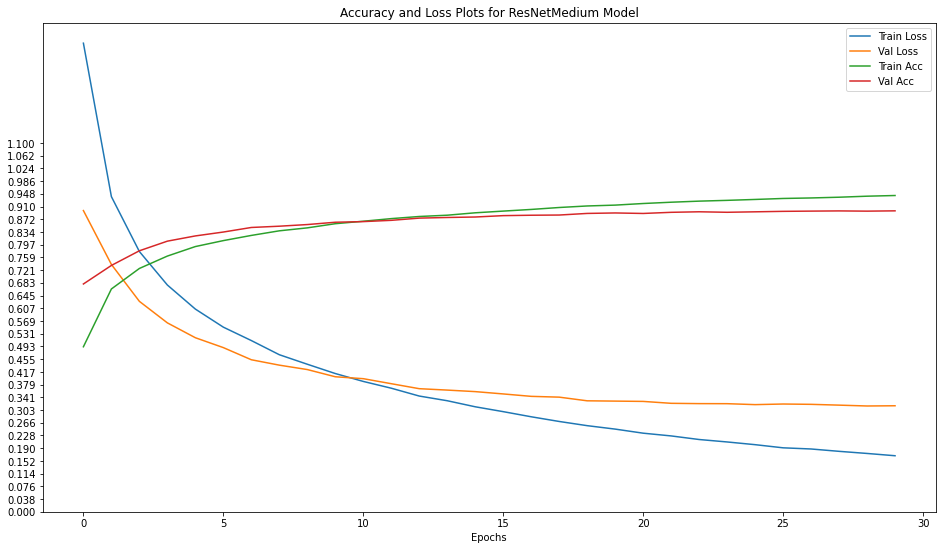

In [20]:
fig, ax = plt.subplots(figsize=(16,9))

plt.title('Accuracy and Loss Plots for ResNetMedium Model')
plt.plot(train_loss_history_large, label='Train Loss')
plt.plot(val_loss_history_large, label='Val Loss')
plt.plot(train_acc_history_large, label='Train Acc')  
plt.plot(val_acc_history_large, label='Val Acc')
plt.legend()
plt.xlabel("Epochs")
yticks = np.linspace(0, 1.1, num=30)
ax.set_yticks(yticks)
plt.show()  

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'airplane'),
  Text(1, 0, 'automobile'),
  Text(2, 0, 'bird'),
  Text(3, 0, 'cat'),
  Text(4, 0, 'deer'),
  Text(5, 0, 'dog'),
  Text(6, 0, 'frog'),
  Text(7, 0, 'horse'),
  Text(8, 0, 'ship'),
  Text(9, 0, 'truck')])

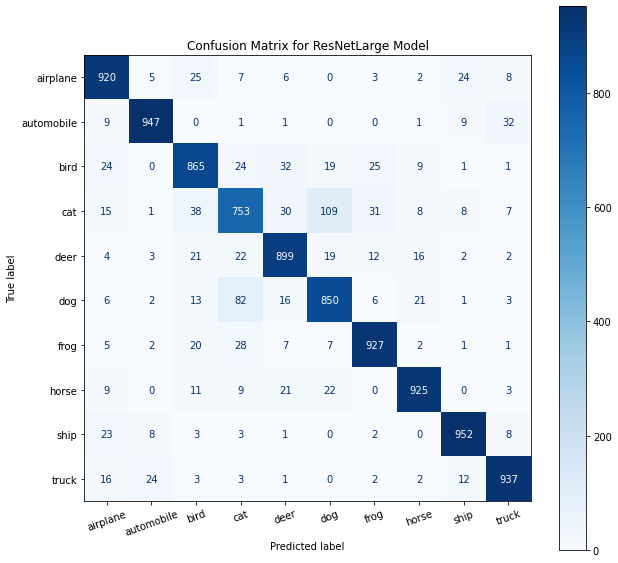

In [21]:
# Calculate the confusion matrix
cm = confusion_matrix(y_true_large, y_pred_large)
fig = plt.figure(figsize = (10, 10));
ax = fig.add_subplot(1, 1, 1);
ax.set_title('Confusion Matrix for ResNetLarge Model')
cm = ConfusionMatrixDisplay(cm, display_labels = classes);
cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
plt.xticks(rotation = 20)

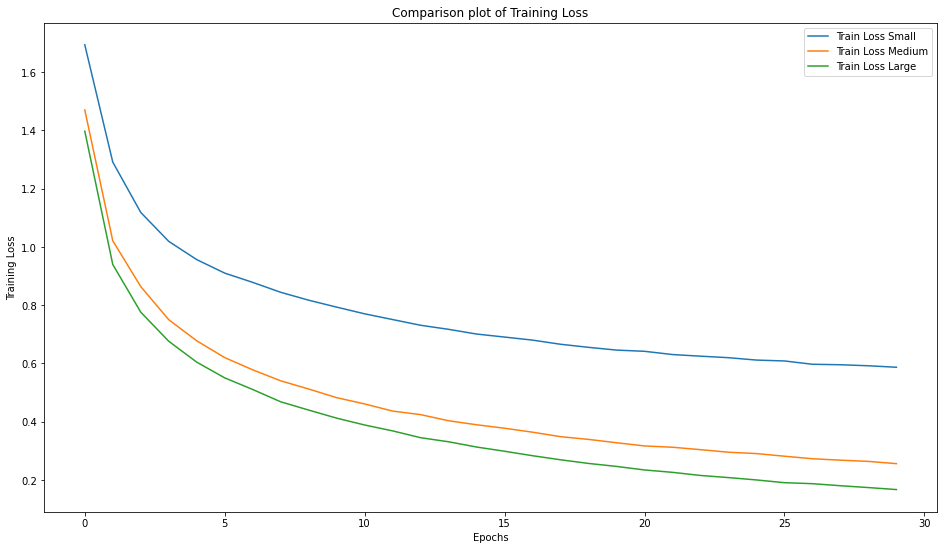

In [24]:
fig, ax = plt.subplots(figsize=(16,9))
plt.title('Comparison plot of Training Loss')
plt.plot(train_loss_history_small, label='Train Loss Small')
plt.plot(train_loss_history_medium, label='Train Loss Medium')
plt.plot(train_loss_history_large, label='Train Loss Large')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.show()  

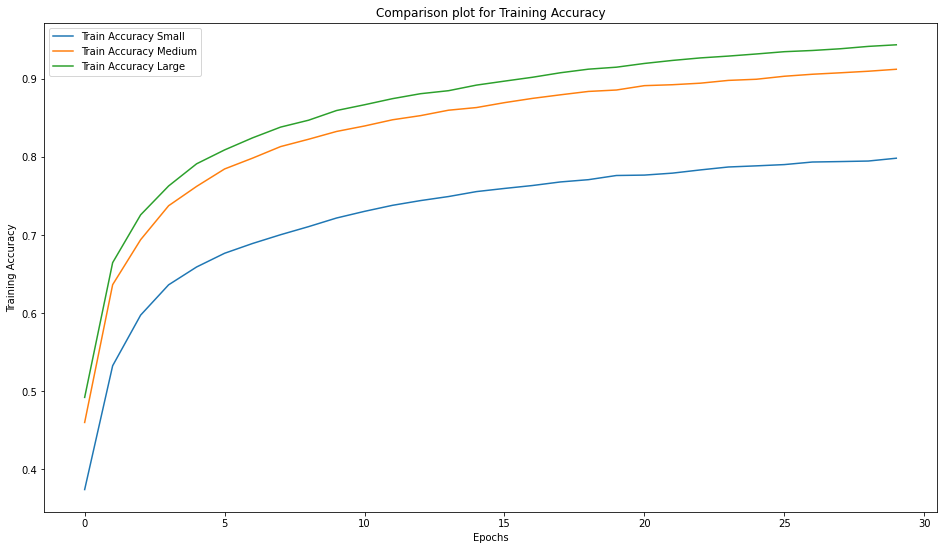

In [25]:
fig, ax = plt.subplots(figsize=(16,9))
plt.title('Comparison plot for Training Accuracy')
plt.plot(train_acc_history_small, label='Train Accuracy Small')
plt.plot(train_acc_history_medium, label='Train Accuracy Medium')
plt.plot(train_acc_history_large, label='Train Accuracy Large')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Training Accuracy")
plt.show()

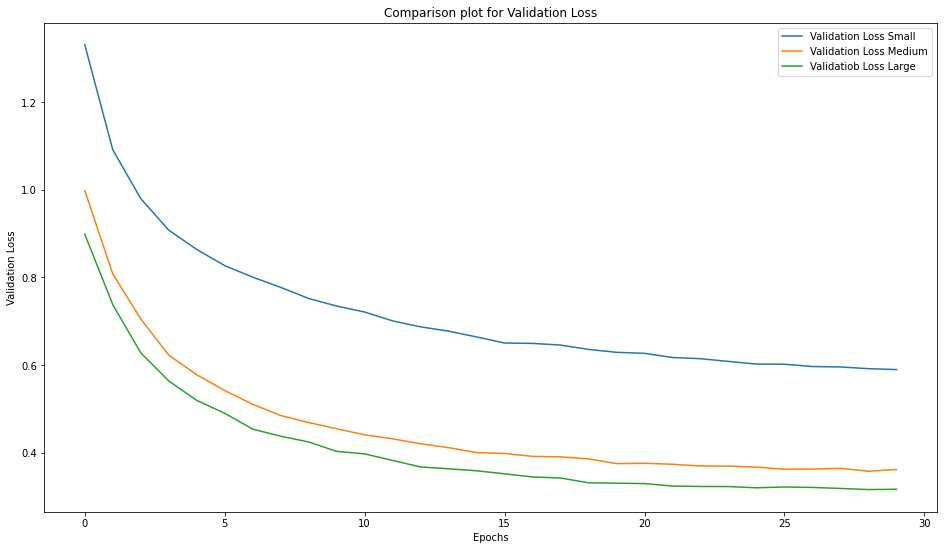

In [26]:
fig, ax = plt.subplots(figsize=(16,9))
plt.title('Comparison plot for Validation Loss')
plt.plot(val_loss_history_small, label='Validation Loss Small')
plt.plot(val_loss_history_medium, label='Validation Loss Medium')
plt.plot(val_loss_history_large, label='Validatiob Loss Large')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.show()

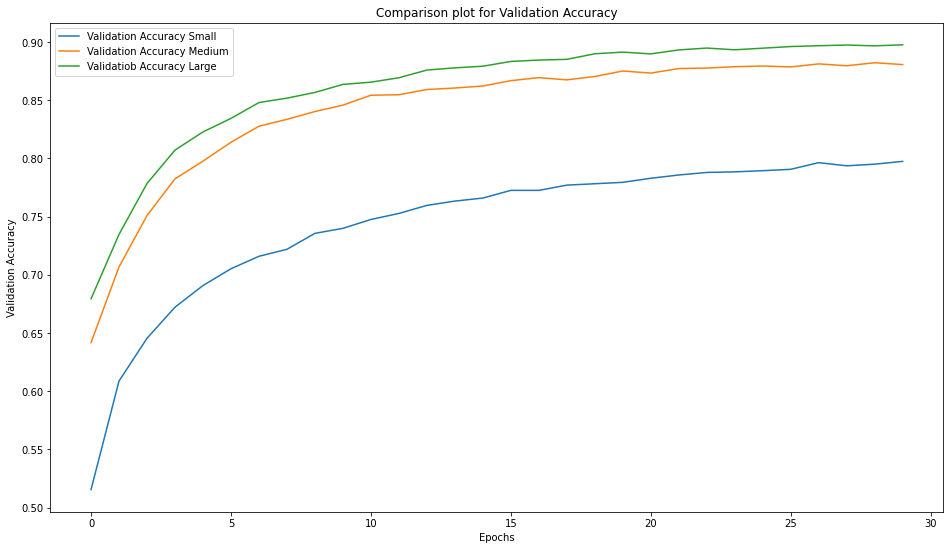

In [27]:
fig, ax = plt.subplots(figsize=(16,9))
plt.title('Comparison plot for Validation Accuracy')
plt.plot(val_acc_history_small, label='Validation Accuracy Small')
plt.plot(val_acc_history_medium, label='Validation Accuracy Medium')
plt.plot(val_acc_history_large, label='Validatiob Accuracy Large')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.show()